<a href="https://colab.research.google.com/github/IImbryk/ReinforcementLearningTraining/blob/main/Class_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Глава 2. Марковские процессы принятия решений  (МППР)  и  динамическое  программирование

In [1]:
import torch

In [6]:
T = torch.tensor([[0.4, 0.6],
                  [0.8, 0.2]]) # определяем матрицу переходов
v = torch.tensor([[0.7, 0.3]]) # начальное распределение двух состояний.

# В дальнешем будет установлено, что от начального распределения состояний 
# не зависит распределение вероятностей состояний после k шагов

In [4]:
T_2 = torch.matrix_power(T, 2) # вероятность перехода после 2 шага
T_20 = torch.matrix_power(T, 20) # вероятность перехода после 20 шага

In [7]:
v_1 = torch.mm(v, T)
v_2 = torch.mm(v, T_2)
v_20 = torch.mm(v, T_20)

In [9]:
print("Вероятность  перехода  после  2  шагов:\n{}".format(T_2))
print("Вероятность  перехода  после  20  шагов:\n{}".format(T_20))

Вероятность  перехода  после  2  шагов:
tensor([[0.6400, 0.3600],
        [0.4800, 0.5200]])
Вероятность  перехода  после  20  шагов:
tensor([[0.5714, 0.4286],
        [0.5714, 0.4286]])


In [10]:
print("Распределение  состояний  после  1  шага:\n{}".format(v_1))
print("Распределение  состояний  после  2  шага:\n{}".format(v_2))
print("Распределение  состояний  после  20  шага:\n{}".format(v_20))

Распределение  состояний  после  1  шага:
tensor([[0.5200, 0.4800]])
Распределение  состояний  после  2  шага:
tensor([[0.5920, 0.4080]])
Распределение  состояний  после  20  шага:
tensor([[0.5714, 0.4286]])


 ## Cоздания МППР

In [11]:
import torch

T = torch.tensor(
    [[[0.8, 0.1, 0.1],
      [0.1, 0.6, 0.3]],
     [[0.7, 0.2, 0.1],
      [0.1, 0.8, 0.1]],
     [[0.6, 0.2, 0.2],
      [0.1, 0.4, 0.5]]]
)

In [16]:
R = torch.tensor([1., 0., -1.]) # функция вознаграждения
gamma = 0.5 # коэффициент дисконтирования

action = 0 # оптимальная стратегия - всегда выбирать действие a0

In [20]:
def cal_value_matrix_inversion(gamma, trans_matrix, reward):
  inv = torch.inverse(torch.eye(reward.shape[0]) - gamma * trans_matrix)
  V = torch.mm(inv, reward.reshape(-1, 1))
  return V

In [21]:
trans_matrix=T[:,action]
V = cal_value_matrix_inversion(gamma, trans_matrix, R) # Функция ценности при оптимальной стратегии

In [18]:
trans_matrix

tensor([[0.8000, 0.1000, 0.1000],
        [0.7000, 0.2000, 0.1000],
        [0.6000, 0.2000, 0.2000]])

##Оценивание  стратегии. Приближенное динамическое программирование

Мы начинаем  со  случайно  выбранных  ценностей  состояний  и  итеративно  обновляем  их,  применяя  уравнение  математического  ожидания    Беллмана,  пока  не достигнем сходимости.

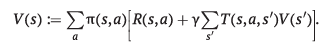

In [22]:
import torch

T = torch.tensor(
    [[[0.8, 0.1, 0.1],
      [0.1, 0.6, 0.3]],
     [[0.7, 0.2, 0.1],
      [0.1, 0.8, 0.1]],
     [[0.6, 0.2, 0.2],
      [0.1, 0.4, 0.5]]]
)

In [31]:
R = torch.tensor([1., 0., -1.])
gamma = 0.5

threshold = 0.0001 # порог остановки процесса оценивания

In [25]:
policy_optimal = torch.tensor([[1.0, 0.0],
                               [1.0, 0.0],
                               [1.0, 0.0]]) #оптимальная стратегия, при которой всегда выбирается a0

In [33]:
def policy_evaluation(policy, trans_matrix, rewards, gamma, treshold):
  """
  оценивает стратегию
  @param policy: матрица, содержащая вероятности выбора действий в каждом состоянии
  """
  n_state = policy.shape[0]
  V = torch.zeros(n_state)
  while True:
    V_temp = torch.zeros(n_state)
    for state, actions in enumerate(policy):
      for action, action_prob in enumerate(actions):
        V_temp[state] += action_prob * (R[state] + gamma * torch.dot(trans_matrix[state,action], V))
    max_delta = torch.max(torch.abs(V - V_temp))
    V = V_temp.clone()
    if max_delta <= threshold:
      break
  return V


In [34]:
V=policy_evaluation(policy_optimal,T,R,gamma,threshold) 
print( "Функция  ценности  при  оптимальной  стратегии:\n{}".format(V))

Функция  ценности  при  оптимальной  стратегии:
tensor([ 1.6786,  0.6260, -0.4821])


Оценивание  стратегии  используется  для  предсказания результатов стратегии,  а не  для решения задач  управления

## Имитация дискретной окружающей среды FrozenLake

S: начальное положение; \\
G: конечное положение, в котором эпизод завершается; \\
F: замерзшее озеро,  по которому можно ходить; \\
H: полынья, в которой эпизод завершается

Определены  четыре  действия:  влево  (0),  вниз  (1),  вправо  (2)  и  вверх  (3). Агенту  начисляется  вознаграждение  +1,  если  он  успешно  доберется  до  цели, и  0  в  противном  случае.  Пространство  наблюдений  представлено  массивом  из 16 целых  чисел,  а возможных  действий  четыре (естественно). У  этой  среды  есть  особенность,  осложняющая  обучение:  поскольку  лед скользкий, агент не  всегда  движется туда, куда  собирался. Например, он  может сдвинуться влево или вправо,  хотя намеревался идти вниз.

In [35]:
import gym
import torch
env = gym.make('FrozenLake-v0')
n_state = env.observation_space.n
n_action = env.action_space.n

print(n_state, n_action)

16 4


In [37]:
env.reset()
env.render()


SFFF
FHFH
FFFH
HFFG


In [38]:
new_state, reward, is_done, info = env.step(1)

In [39]:
env.render()

  (Down)
SFFF
FHFH
FFFH
HFFG


In [40]:
def run_episode(env, policy):
  state = env.reset()
  total_reward = 0
  is_done = False
  while not is_done:
    action = policy[state].item()
    state, reward, is_done, infp = env.step(action)
    total_reward += reward
    if is_done:
      break

  return total_reward

In [ ]:
n_episode = 1000
total_rewards = []
for episode in range(n_episode):
  random_policy = torch.randint(high=n_action, size=(n_state,))

##Решение МППР С Помощью алгоритма итерации по ценности

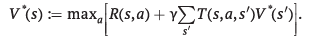

Вычислив оптимальную ценность, получаем оптимальную стратегию:
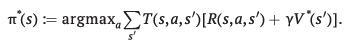

In [41]:
import gym
import torch
env = gym.make('FrozenLake-v0')

gamma = 0.99 # при малом  коэффициенте  предпочтение отдается  непосредственному  вознаграждению,  а  при  большом  учитываются и будущие вознаграждения.
threshold = 0.0001

In [45]:
def value_iteration(env, gamma, threashold):
  n_state = env.observation_space.n
  n_action = env.action_space.n

  V = torch.zeros(n_state)

  while True:
    V_temp = torch.empty(n_state)
    for state in range(n_state):
      v_actions = torch.zeros(n_action)
      for action in range(n_action):
        for trans_prob, new_state, reward, _ in env.env.P[state][action]:
          v_actions[action] += trans_prob * (reward + gamma * V[new_state])
      V_temp[state] = torch.max(v_actions)
    max_delta = torch.max(torch.abs(V - V_temp))
    V = V_temp.clone()
    if max_delta <= threshold:
        break
  return V


In [50]:
def extract_optimal_policy(env, V_optimal, gamma):
  n_state = env.observation_space.n
  n_action = env.action_space.n

  optimal_policy = torch.zeros(n_state)

  for state in range(n_state):
    v_action = torch.zeros(n_action)
    for action in range(n_action):
      for trans_prob, new_state, reward, _ in env.env.P[state][action]:
        v_action[action] += trans_prob * (reward + gamma * V_optimal[new_state])
    optimal_policy[state] = torch.argmax(v_action)
  return optimal_policy

In [47]:
V_optimal=value_iteration(env,gamma,threshold)
print('Оптимальные  ценности:\n{}'.format(V_optimal))

Оптимальные  ценности:
tensor([0.5404, 0.4966, 0.4681, 0.4541, 0.5569, 0.0000, 0.3572, 0.0000, 0.5905,
        0.6421, 0.6144, 0.0000, 0.0000, 0.7410, 0.8625, 0.0000])


In [51]:
optimal_policy=extract_optimal_policy(env,V_optimal,gamma)
print('Оптимальная стратегия:\n{}'.format(optimal_policy))

Оптимальная стратегия:
tensor([0., 3., 3., 3., 0., 0., 0., 0., 3., 1., 0., 0., 0., 2., 1., 0.])


##Игра с подбрасыванием монеты

В  каждом  раунде игрок  ставит  на  выпадение  орла.  Если  действительно  выпал  орел,  игрок  получает ту  сумму, которую  поставил, в  противном  случае теряет  свою  ставку. Игра продолжается  до  разорения  игрока  или  до  выигрыша  определенной  суммы (скажем,  больше  100  долларов).  Предположим,  что  монета  несимметричная, так  что  орел  выпадает  в  40  %  случаев.  Сколько  должен  поставить  игрок,  чтобы  максимизировать  шансы  на  выигрыш,  с  учетом  своего  текущего  капитала в каждом раунде? 

Состояние - это капитал игрока в долларах (всего 101 состояние) \\
Вознаграждение -1 если достигнуто 100+, иначе 0 \\
Действие - это сумма, которую игрок ставит в раунде(1,2... 100-s) \\
Терминальные состояние - это 0 или 100+ \\

In [52]:
import torch

In [54]:
gamma = 1 #здесь обесценивания нет
threshold = 1e-10 # порог сходимости


capital_max = 100
n_state = capital_max + 1
head_prob = 0.4


In [55]:
rewards = torch.zeros(n_state)
rewards[-1] = 1

In [56]:
env = {'capital_max':capital_max,
       'head_prob': head_prob,
       'rewards': rewards,
       'n_state': n_state}

In [64]:

def value_iteration(env, gamma, threshold):
  """
  алгоритм итерации по ценности
  """

  head_prob=env['head_prob']
  n_state=env['n_state']
  capital_max=env['capital_max']

  V = torch.zeros(n_state)
  while True:
    V_temp = torch.zeros(n_state)
    for state in range(1, capital_max):
      v_actions = torch.zeros(min(state, capital_max - state) + 1)
      for action in range(1, min(state, capital_max - state) + 1):
        v_actions[action] += head_prob * (rewards[state+action] + gamma*V[state + action])
        v_actions[action] += (1-head_prob) * (rewards[state-action] + gamma*V[state - action])
      V_temp[state] = torch.max(v_actions)
    max_delta = torch.max(torch.abs(V - V_temp))
    V = V_temp.clone()
    if max_delta <= threshold:
      break
  return V


In [69]:
def extract_optimal_policy(env, V_optimal, gamma):
  """
  построение оптимальной стратегии по оптимальным ценностям
  """

  head_prob=env['head_prob']
  n_state=env['n_state']
  capital_max=env['capital_max']

  optimal_policy = torch.zeros(capital_max).int()

  for state in range(1, capital_max):
    v_actions = torch.zeros(capital_max)
    for action in range(1, min(state, capital_max - state) + 1):
      v_actions[action] += head_prob * (rewards[state+action] + gamma*V_optimal[state + action])
      v_actions[action] += (1-head_prob) * (rewards[state-action] + gamma*V_optimal[state - action])
    optimal_policy[state] = torch.argmax(v_actions)
  return optimal_policy

In [70]:
import time
start_time = time.time()

V_optimal = value_iteration(env, gamma, threshold)
optimal_policy = extract_optimal_policy(env, V_optimal, gamma)
print("Для решения методом итерации по ценности понадобилось {:.3f}с".format(time.time()-start_time))

Для решения методом итерации по ценности понадобилось 6.010с


In [71]:
print('Оптимальные  ценности:\n{}'.format(V_optimal)) 
print('Оптимальная  стратегия:\n{}'.format(optimal_policy))

Оптимальные  ценности:
tensor([0.0000, 0.0021, 0.0052, 0.0092, 0.0129, 0.0174, 0.0231, 0.0278, 0.0323,
        0.0377, 0.0435, 0.0504, 0.0577, 0.0652, 0.0695, 0.0744, 0.0807, 0.0866,
        0.0942, 0.1031, 0.1087, 0.1160, 0.1259, 0.1336, 0.1441, 0.1600, 0.1631,
        0.1677, 0.1738, 0.1794, 0.1861, 0.1946, 0.2017, 0.2084, 0.2165, 0.2252,
        0.2355, 0.2465, 0.2579, 0.2643, 0.2716, 0.2810, 0.2899, 0.3013, 0.3147,
        0.3230, 0.3339, 0.3488, 0.3604, 0.3762, 0.4000, 0.4031, 0.4077, 0.4138,
        0.4194, 0.4261, 0.4346, 0.4417, 0.4484, 0.4565, 0.4652, 0.4755, 0.4865,
        0.4979, 0.5043, 0.5116, 0.5210, 0.5299, 0.5413, 0.5547, 0.5630, 0.5740,
        0.5888, 0.6004, 0.6162, 0.6400, 0.6446, 0.6516, 0.6608, 0.6690, 0.6791,
        0.6919, 0.7026, 0.7126, 0.7248, 0.7378, 0.7533, 0.7697, 0.7868, 0.7965,
        0.8075, 0.8215, 0.8349, 0.8520, 0.8721, 0.8845, 0.9009, 0.9232, 0.9406,
        0.9643, 0.0000])
Оптимальная  стратегия:
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 